#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

<!-- You have until midnight of 07/05/23 to submit your mini-projects. You will be requested to upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation:
    - A table with model comparison: linear regression from stimuli, task-driven models (trained and random), data-driven models and your best model
    - A figure showing how the neural prediction changes across layer of a task-driven model
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage on the validation set. -->

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=9c00d017-225b-41b0-8ab9-27400f910925
To: /home/jupyter/Brain_like_mini_project/IT_data.h5
100%|██████████| 384M/384M [00:03<00:00, 103MB/s]  


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channels (RGB)
The size of the image is 224x224


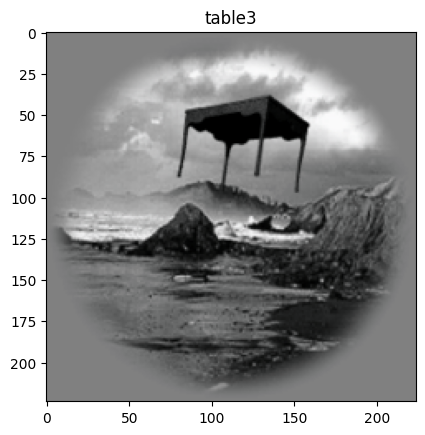

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

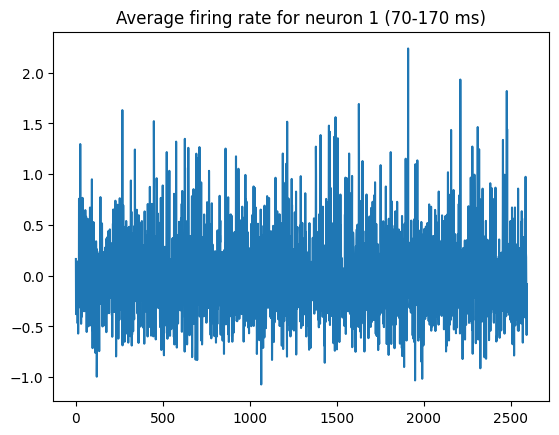

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [7]:
from sklearn.linear_model import Ridge

#data
X = stimulus_train.reshape(stimulus_train.shape[0], stimulus_train.shape[1]*stimulus_train.shape[2]*stimulus_train.shape[3])
y = spikes_train

In [8]:
#ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.02974e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge()

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

Text(0.5, 1.0, 'EV using all features')

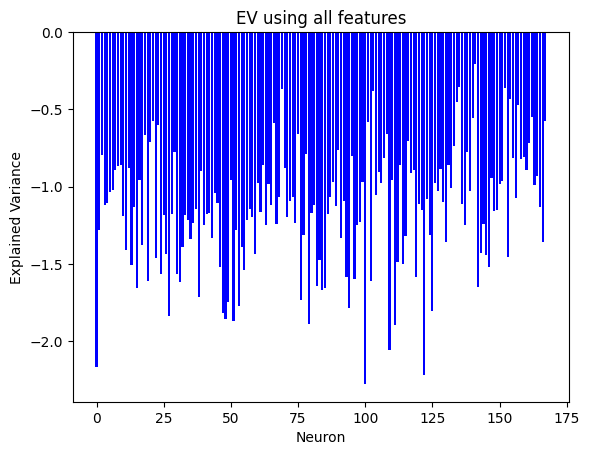

In [9]:
import numpy as np
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt

y_pred = ridge_model.predict(stimulus_val.reshape(stimulus_val.shape[0], stimulus_val.shape[1]*stimulus_val.shape[2]*stimulus_val.shape[3]))

correlation_scores = []
explained_variance_scores = []

for i in range(y.shape[1]):
    # Calculate correlation
    corr = np.corrcoef(spikes_val[:, i], y_pred[:, i])[0, 1]
    correlation_scores.append(corr)

    # Calculate explained variance
    explained_variance = explained_variance_score(spikes_val[:, i], y_pred[:, i])
    explained_variance_scores.append(explained_variance)

plt.bar(range(y.shape[1]), explained_variance_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Explained Variance')
plt.title('EV using all features')

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity.

Text(0.5, 1.0, 'EV using 1000 PCs')

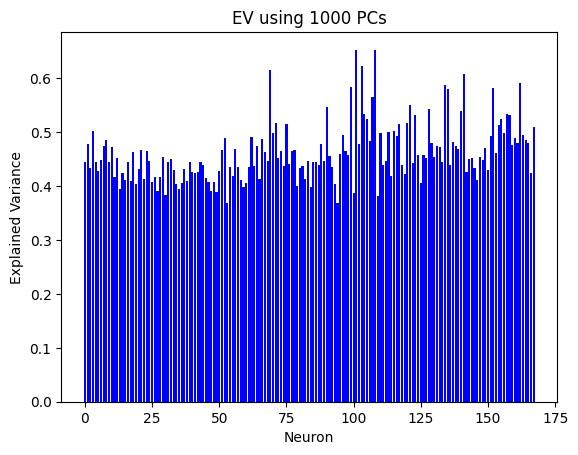

In [10]:
from sklearn.decomposition import PCA

# Project the stimulus on its first 1000 PCs
pca = PCA(n_components=1000)
X_reduced = pca.fit_transform(X)

# Re-train with lower-dimensional data
ridge_model_reduced = Ridge(alpha=1.0)
ridge_model_reduced.fit(X_reduced, y)

# Do the same analysis as above but with ridhe_model_reduced
y_pred_reduced = ridge_model_reduced.predict(X_reduced)

correlation_scores_reduced = []
explained_variance_scores_reduced = []

for i in range(y.shape[1]):
    # Correlation
    corr = np.corrcoef(y[:, i], y_pred_reduced[:, i])[0, 1]
    correlation_scores_reduced.append(corr)

    # Explained variance
    explained_variance = explained_variance_score(y[:, i], y_pred_reduced[:, i])
    explained_variance_scores_reduced.append(explained_variance)

plt.bar(range(y.shape[1]), explained_variance_scores_reduced, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Explained Variance')
plt.title('EV using 1000 PCs')

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

alphas = np.logspace(start=-4, stop=1, num=25)

# Use StratifiedKFold to preserve the percentage of samples for each class
skf = StratifiedKFold()
ev_alphas = []

for i in range(len(alphas)):

    ev_alpha = []
    rr_alpha = Ridge(alpha=alphas[i])

    for train_index, val_index in skf.split(X_reduced, np.array(objects_train)):
        x_train_fold, x_val_fold = X_reduced[train_index], X_reduced[val_index]
        y_train_fold, y_val_fold = spikes_train[train_index], spikes_train[val_index]

        # Fit the model using train data
        rr_alpha.fit(x_train_fold, y_train_fold)

        # Evaluate the model using validation data
        y_pred = rr_alpha.predict(x_train_fold)

        ev_tot = []
        for i in range(y_val_fold.shape[1]):
            ev_neuron = explained_variance_score(y_train_fold[:, i], y_pred[:, i])
            ev_tot.append(ev_neuron)

        ev_alpha.append(np.mean(ev_tot))

    ev_alphas.append(np.mean(ev_alpha))

In [12]:
best_alpha=alphas[np.argmax(ev_alphas)]

The model variance is GREATER than the true variance..., but the Pythagorean theorem states that $$\sum_{i=1}^{n}(y_i - \bar{y})^2 = \sum_{i=1}^{n}(\hat{y}_i - \bar{y})^2 + \sum_{i=1}^{n}(y_i - \hat{y}_i)^2.
$$


### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [13]:
!pip install torchvision

In [14]:
import torch
import torchvision.models as models
from sklearn.decomposition import PCA

In [15]:
resnet50_model = models.resnet50(pretrained=True)
resnet50_model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Create DataLoader and DataSet to have batches

In [16]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [17]:
# To Store each activation in a dictionary : 
ACTIVATIONS  = {}

In [18]:
class Dataset(Dataset):
    def __init__(self, stim, obj):
        self.features = stim
        self.target = obj

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        X = self.features[idx]
        y = self.target[idx]

        return X, y
    
# Initialize the dataset and loader

training_data = Dataset(stimulus_train, objects_train) 
#test_data = Dataset(stimulus_test, objects_test) 
#val_data = Dataset(stimulus_val, objects_val) 

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True) #batch size to change ??
#test_dataloader = DataLoader(test_data, batch_size=1000, shuffle=True)
#val_dataloader = DataLoader(val_data, batch_size = 1000, shuffle = True)

### Extract the activations

In [19]:
# hook function
def hook(model, input, output):
    activations.append(output.detach().reshape(output.shape[0], -1))

##### conv1

In [20]:
# Define the layer of interest 
layer = 'conv1' #['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size

In [21]:
# Storage
ACTIVATIONS['conv1'] = act_reduced

##### layer1

In [23]:
# Define the layer of interest 
layer = 'layer1' 

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size

In [25]:
# Storage
ACTIVATIONS['layer1'] = act_reduced

##### layer2

In [26]:
# Define the layer of interest 
layer = 'layer2'

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size

In [27]:
# Storage
ACTIVATIONS['layer2'] = act_reduced

##### layer3

In [28]:
# Define the layer of interest 
layer = 'layer3'

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size

In [29]:
# Storage
ACTIVATIONS['layer3'] = act_reduced

##### layer4

In [30]:
# Define the layer of interest 
layer =  'layer4'

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size

In [31]:
# Storage
ACTIVATIONS['layer4'] = act_reduced

##### avgpool

In [32]:
# Define the layer of interest 
layer = 'avgpool'

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size

In [33]:
# Storage
ACTIVATIONS['avgpool'] = act_reduced

## SAVING (just to be sure)

In [74]:
import pandas as pd
import os.path

for layer_name in ACTIVATIONS.keys() :
    act_to_store = pd.DataFrame(ACTIVATIONS[layer_name])
    act_to_store.to_csv(f'Activations/{layer_name}.csv')

## function to do it at once (doesn't work for now)

In [41]:
def extract_activation(dataloader, layername, ACTIVATIONS):
    # hook function
    def hook(model, input, output):
        activations.append(output.detach().reshape(output.shape[0], -1))

    # Set the PCA function 
    pca = PCA(n_components=1000)

    # Interate throught the batches and store the activations
    activations = []
    hook_handle = resnet50_model.conv1.register_forward_hook(hook)

    for batch_x, batch_y in train_dataloader:
        resnet50_model(batch_x)
    
    act_reduced = pca.fit_transform(np.concatenate(activations))

    # Remove the hook at the end of the forward
    hook_handle.remove()
    
    # Store
    ACTIVATIONS[layername] = act_reduced

In [ ]:
ACTIVATIONS = {}
target_layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

for layer_name in target_layers:
    print('current layer:', layer_name) 
    extract_activation(train_dataloader, layer_name, ACTIVATIONS)
    print('layer completed:', ACTIVATIONS.keys())

current layer conv1


## Ridge regression for each layer

In [46]:
# Use the PCs of each layer to predict the neural activity using the linear regression model developed before.
out = {}
for layer_name, activation in ACTIVATIONS.items():
    out[layer_name] = ridge_model_reduced.predict(activation) #expected 1000 features

In [47]:
correlation = {}
explained_variance = {}

In [49]:
# Compute the goodness of fit using the correlation and explained variance metrics.
# Do we predict the neural activity better than before?
for layer_name, activation in ACTIVATIONS.items():
    y_pred = out[layer_name]
    correlation_scores = [] 
    explained_variance_scores = [] 
    
    for i in range(y_pred.shape[1]):
        # Correlation
        corr = np.corrcoef(y[:, i], y_pred[:, i])[0, 1]
        correlation_scores.append(corr)

        # Explained variance
        ev = explained_variance_score(y[:, i], y_pred[:, i])
        explained_variance_scores.append(ev)

    correlation[layer_name] = correlation_scores
    explained_variance[layer_name] = explained_variance_scores

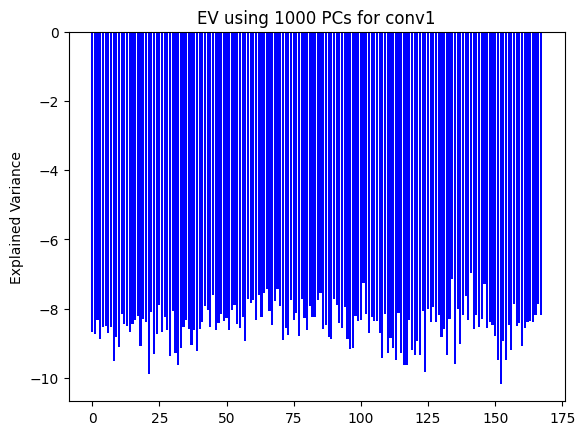

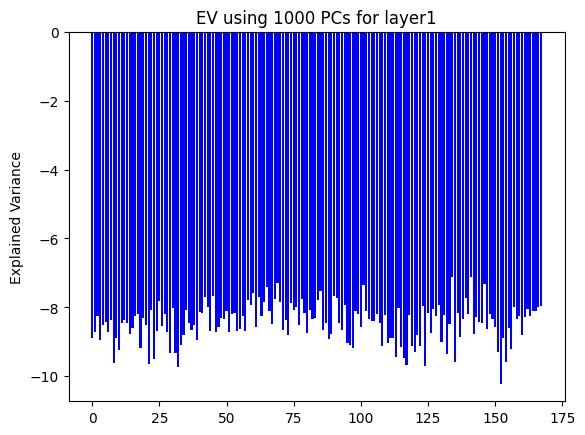

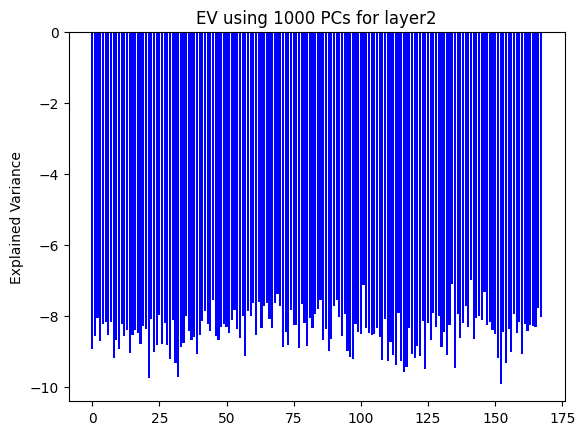

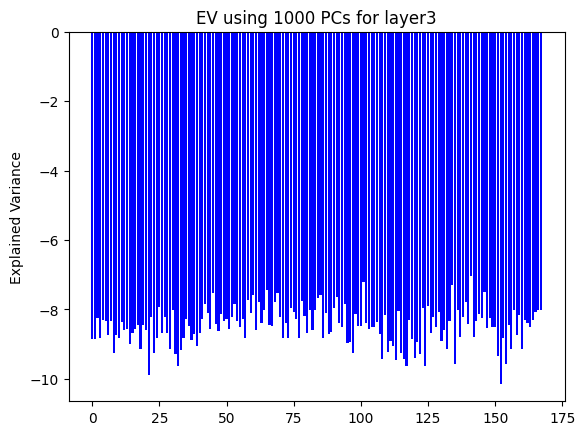

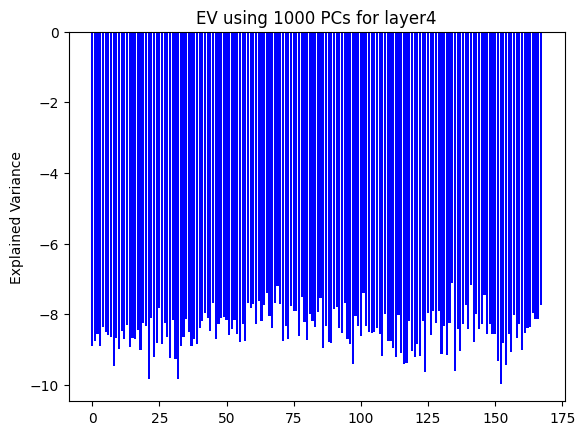

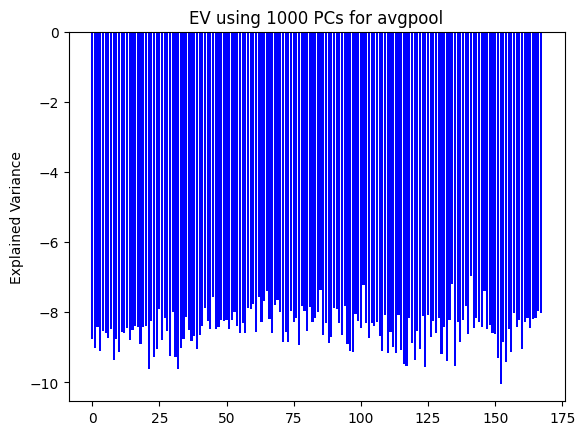

In [55]:
# Plot the distribution of explained variance with respect to the layer of the network, order them based on the depth.
# How does the neural activity changes across the model layers, can you make some statements about it?

for layer_name, expl_var in explained_variance.items():
    fig, ax = plt.subplots()
    ax.bar(range(len(expl_var)), expl_var, color='blue')
    ax.set_ylabel('Explained Variance')
    ax.set_title(f"EV using 1000 PCs for {layer_name}")

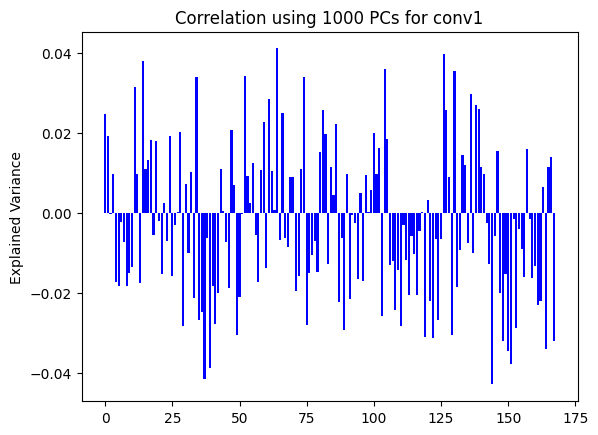

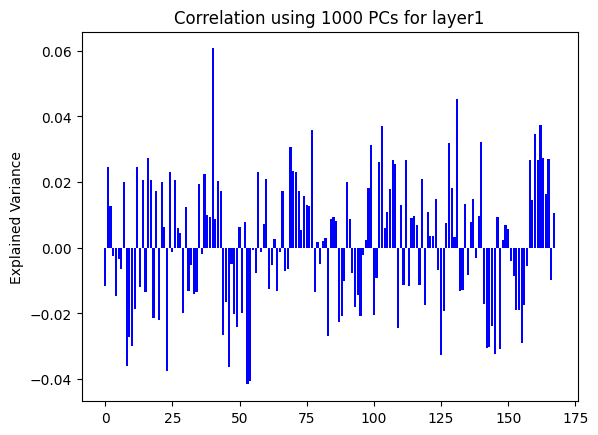

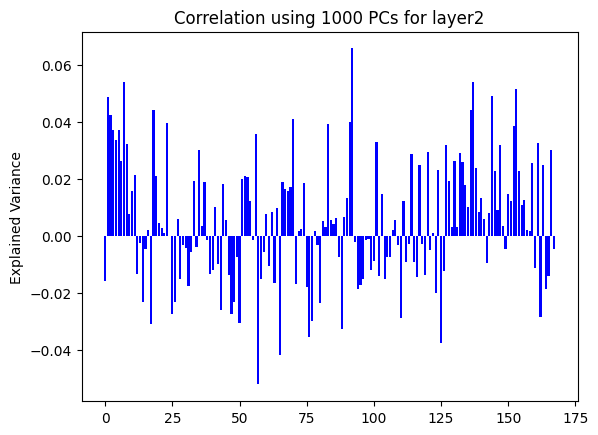

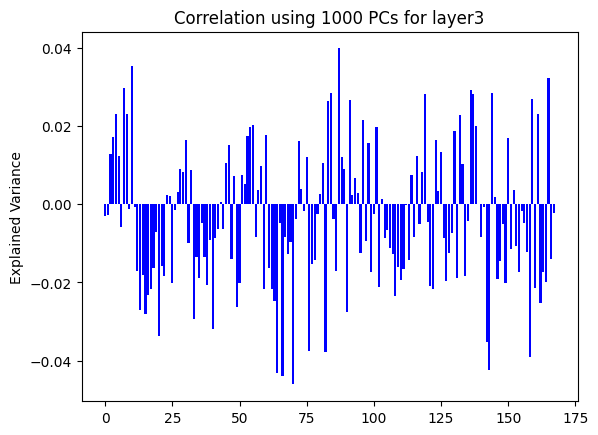

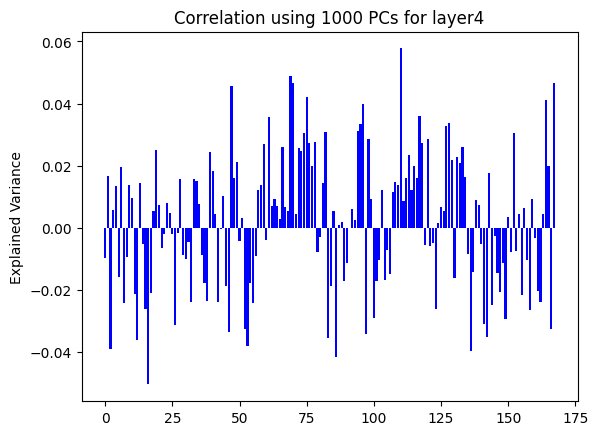

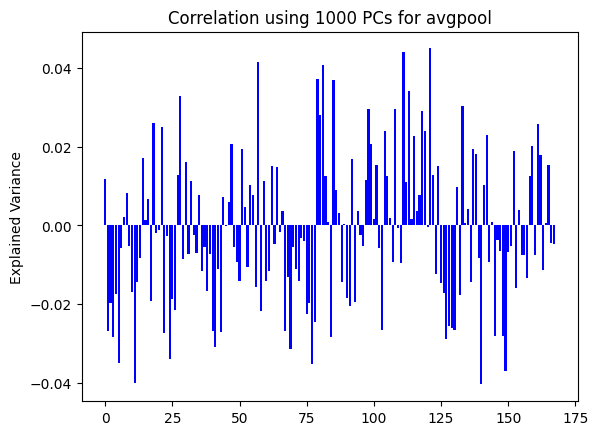

In [56]:
for layer_name, corr in correlation.items():
    fig, ax = plt.subplots()
    ax.bar(range(len(corr)), corr, color='blue')
    ax.set_ylabel('Explained Variance')
    ax.set_title(f"Correlation using 1000 PCs for {layer_name}")

<BarContainer object of 6 artists>

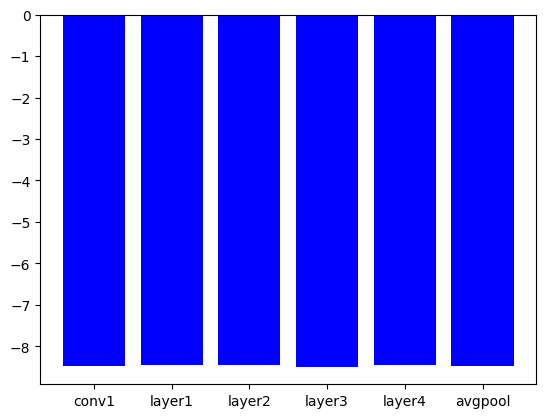

In [52]:
evs = [np.mean(ev) for layer_name, ev in explained_variance.items()]  
plt.bar(explained_variance.keys(), evs, color='blue')

<BarContainer object of 6 artists>

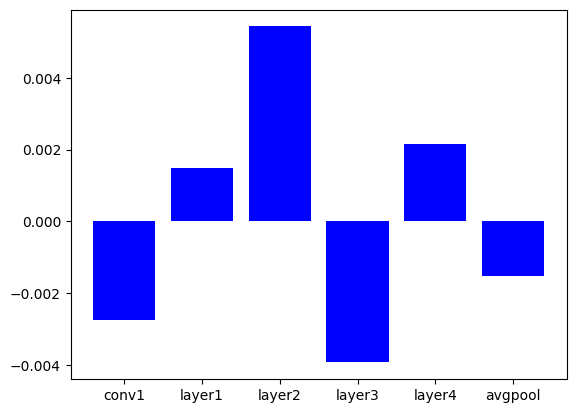

In [53]:
correl = [np.mean(corr) for layer_name, corr in correlation.items()]  
plt.bar(correlation.keys(), correl, color='blue')

## Rondomly initialized model 

In [54]:
# Rdn initialized model 
rnd_resnet50_model = models.resnet50()

In [ ]:
# Define the layer of interest 
layer = 'conv1' #['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    rnd_resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [ ]:
# Storage
ACTIVATIONS_RND['conv1'] = act_reduced

In [ ]:
# Define the layer of interest 
layer = 'layer1' 

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    rnd_resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [ ]:
# Storage
ACTIVATIONS_RND['layer1'] = act_reduced

In [ ]:
# Define the layer of interest 
layer =  'layer2'

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    rnd_resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [ ]:
# Storage
ACTIVATIONS_RND['layer2'] = act_reduced

In [ ]:
# Define the layer of interest 
layer = 'layer3' 

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    rnd_resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [ ]:
# Storage
ACTIVATIONS_RND['layer3'] = act_reduced

In [ ]:
# Define the layer of interest 
layer = 'layer4'

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    rnd_resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [ ]:
# Storage
ACTIVATIONS_RND['layer4'] = act_reduced

In [ ]:
# Define the layer of interest 
layer = 'avgpool'

# Set the PCA funciton 
pca = PCA(n_components=1000)

# Interate throught the batches and store the activations
activations = []
hook_handle = resnet50_model.conv1.register_forward_hook(hook)

for batch_x, batch_y in train_dataloader:
    rnd_resnet50_model(batch_x)
    
act_reduced = pca.fit_transform(np.concatenate(activations))

# Remove the hook at the end of the forward
hook_handle.remove()

In [ ]:
# Storage
ACTIVATIONS_RND['avgpool'] = act_reduced

In [ ]:
import pandas as pd
import os.path

for layer_name in ACTIVATIONS_RND.keys() :
    act_to_store = pd.DataFrame(ACTIVATIONS_RND[layer_name])
    act_to_store.to_csv(f'Activations_RND/{layer_name}.csv')